<a href="https://colab.research.google.com/github/RitheshwrBK/CIFAR10-project/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )


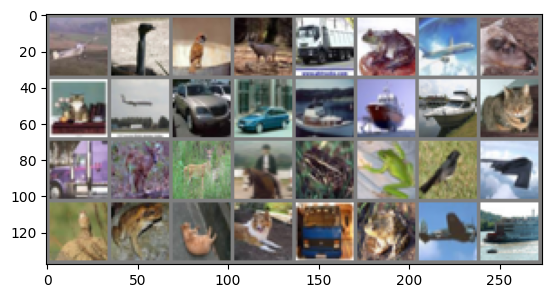

In [37]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Subset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
devtest  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# split the devtest into two separate sets
randidx = np.random.permutation(10000)   # a random permutation of indices
devset  = Subset(devtest,randidx[:6000]) # Subset for devset
testset = Subset(devtest,randidx[6000:]) # Subset for test
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(devset,  batch_size=batchsize) # note: devtest in batches!
test_loader  = DataLoader(testset, batch_size=len(testset))

print(trainset)
print(testset)



def dispimage(img):
  img = img/2 +0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()



dataiter = iter(trainset_loader)
images,labels = dataiter.__next__()



dispimage(torchvision.utils.make_grid(images))

In [38]:
# Uh oh! It looks like the images are the wrong dimensions!
# They need to be 3x32x32.
# And they are not normalized!

# but...
X,y = next(iter(trainset_loader))

# try again
print('Data shapes (train/test):')
print( X.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([32, 3, 32, 32])

Data value range:
(tensor(-1.), tensor(1.))


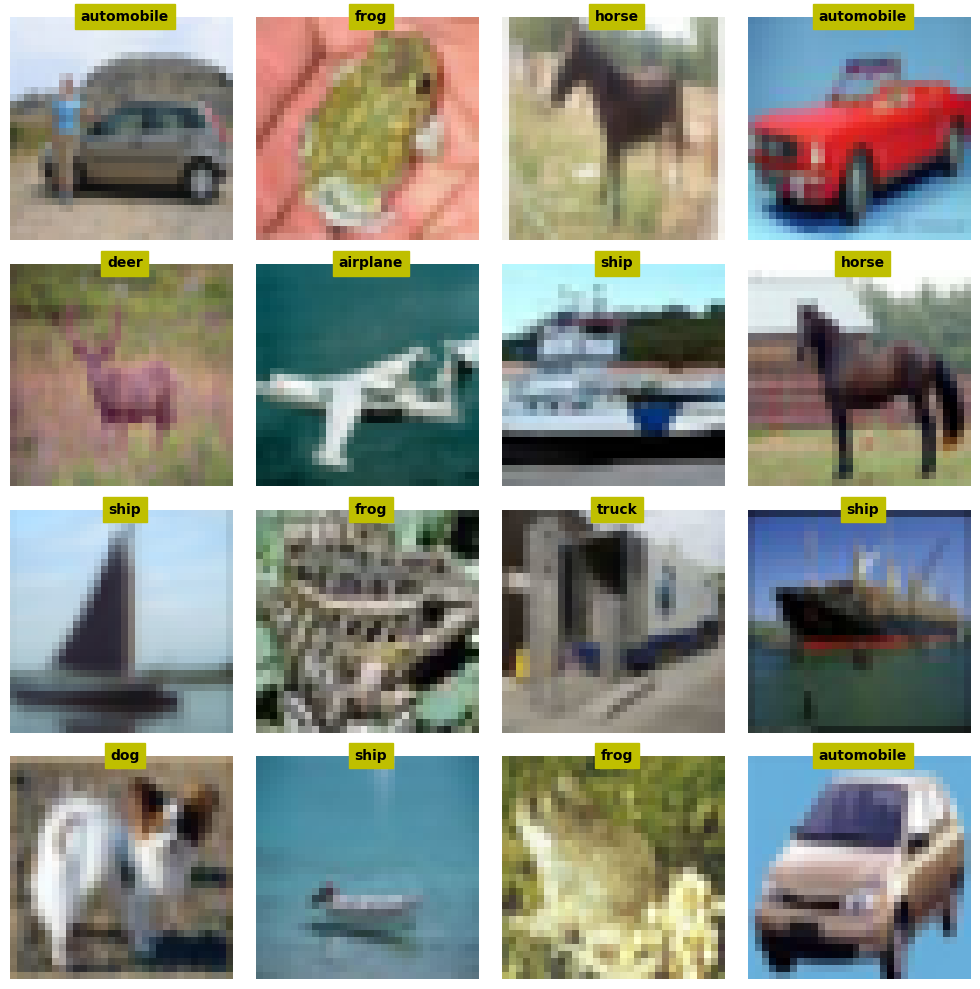

In [39]:
# inspect a few random images

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [40]:
import torch.nn as nn
import torch.nn.functional as F


In [41]:
def createcifarnet():
  class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3,64,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(64)
      self.conv2 = nn.Conv2d(64,128,3)
      self.bnorm2 = nn.BatchNorm2d(128)
      self.conv3 = nn.Conv2d(128,256,3)
      self.bnorm3 = nn.BatchNorm2d(256)


      self.fullyconnected1 = nn.Linear(2*2*256,256)
      self.fullyconnected2 = nn.Linear(256,64)
      self.fullyconnected3 = nn.Linear(64,10)
       #output nodes are 10 because there are 10 classes



    def forward(self,x):
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))

      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits)) # flatten the images to input into fc
      x = F.leaky_relu(self.fullyconnected1(x))
      x = F.dropout(x,p=.5,training=self.training)  #normalizing
      x = F.leaky_relu(self.fullyconnected2(x))
      x = F.dropout(x,p=.5,training=self.training)
      x = self.fullyconnected3(x)

      return x


  print(device)
  net = Net()

  lossfun = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5)

  return net,lossfun,optimizer






In [42]:
# test the model with one batch
net,lossfun,optimizer = createcifarnet()

X,y = next(iter(trainset_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# now compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

cuda:0

Output size:
torch.Size([32, 10])
 
Loss:
tensor(2.3102, grad_fn=<NllLossBackward0>)


Creating a Function that trains the model

In [43]:
def function2trainTheModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = createcifarnet()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss   = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  devAcc    = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train() # switch to train mode
    batchLoss = []
    batchAcc  = []
    for X,y in trainset_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)


    #### test performance (here done in batches!)
    net.eval() # switch to test mode
    batchAcc  = []
    batchLoss = []
    for X,y in dev_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      with torch.no_grad():
        yHat = net(X)
        loss = lossfun(yHat,y)

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    devLoss[epochi] = np.mean(batchLoss)
    devAcc[epochi]  = 100*np.mean(batchAcc)

  # end epochs

  # function output
  return trainLoss,devLoss,trainAcc,devAcc,net

In [44]:
trainLoss,devLoss,trainAcc,devAcc,net = function2trainTheModel()


cuda:0


In [47]:
## the real test set!

net.eval() # switch to test mode
X,y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = net(X)
  loss = lossfun(yHat,y)

# loss and accuracy from this batch
testLoss = loss.item()
testAcc  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

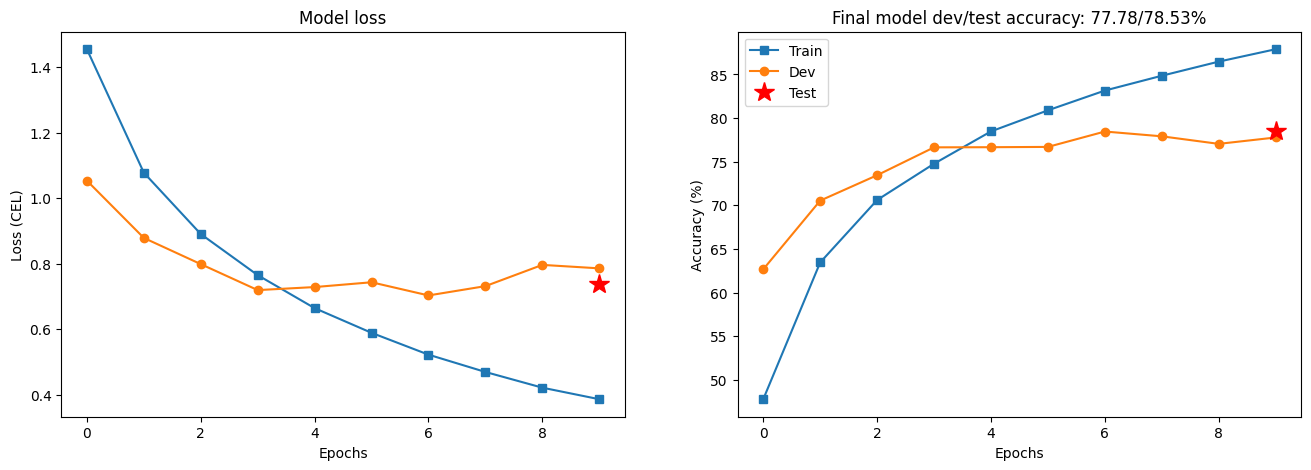

In [48]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
ax[0].plot(len(devLoss)-1,testLoss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Dev')
ax[1].plot(len(devAcc)-1,testAcc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {devAcc[-1]:.2f}/{testAcc:.2f}%')
ax[1].legend()

plt.show()